# AR (Autoregressive) Model

AR(p) (AutoRegressive of order p)는 간단하게 과거의 패턴이 지속된다면 <br>
시계열 데이터 관측치 $ y_t $ 는 과거 관측치 $ y_{t-1} $, $ y_{t-2} $, $ y_{t-3} $, ... 에 의해 예측될 수 있다고 봅니다. <br>
오직 과거의 데이터(lagged variables)만 사용해서 예측 모형을 만들게 되며, 이름도 autoregressive 입니다. (그리스어로 auto 라는 뜻은 "self"를 가르킵니다.)<br>



$$ \begin{align}
X_t &= \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + \epsilon_t + c  \\
&= c + \sum^p_{i=1} \alpha_i X_{t-i} + \epsilon_t
\end{align}$$ 

* **order:** $ p $ 는 모델에서 사용된 lagged variables의 갯수
* **parameters (coefficients):** $ \alpha_1 $, $ \alpha_2 $, ..., $ \alpha_p $
* **error term (white noise):** $ \epsilon_t $

즉 time lag operator를 사용하면 다음과 같이 공식을 세울 수 있습니다.<br>
그리고 아래의 notation은 ARMA (autoregressive moving average)와 동일합니다.

$$ \left( 1 - \sum^p_{k=1} \alpha_k L^k \right) X_t = \epsilon_t $$

이때 다음과 같은 조건들을 갖습니다.

$$ \begin{align} 
|\alpha| &< 1 \\
Var[X_t] &= \frac{\sigma^2}{1-\sigma^2}
\end{align} $$

예를 들어서 order $ p $ 값이 2인 AR(2) 를 구하면 다음과 같습니다.

$$ x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} + \epsilon_t  $$


> <span style="color:red;"> AR은 일반적으로 t+7 정도밖에 예측을 못합니다. <br>
> 데이터에 따라서 다르지만, 실전에 들어가면 워낙 랜덤한 부분이 많아서 제대로 예측을 못합니다.

## Import


In [1]:
%pylab inline
import math
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels import api as sm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data

            passenger
1949-01-01      112.0
1949-02-01      118.0
1949-03-01      132.0
1949-04-01      129.0
1949-05-01      121.0


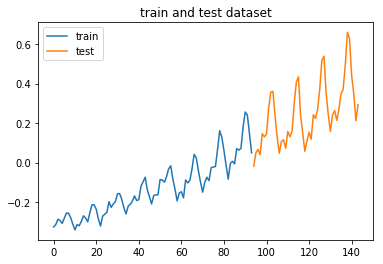

In [2]:
TEST_SIZE = 50

def get_data():
    dataframe = pd.read_csv('/dataset/time-series/international-airline-passengers/international-airline-passengers.csv', 
                       names=[ 'passenger'], index_col=0,
                       skiprows=1)
    dataframe.index = pd.to_datetime(dataframe.index)
    dataframe = dataframe.astype('float64')


    scaler = MinMaxScaler()
    data = scaler.fit_transform(dataframe.values.reshape((-1, 1)))

    # Mean Adjusted Time Series
    mu = np.mean(data)
    data_adjusted = data - mu

    train, test = data_adjusted[:-TEST_SIZE], data_adjusted[-TEST_SIZE:]
    
    return dataframe, data_adjusted, train, test

dataframe, data_adjusted, train, test = get_data()

print(dataframe.head())
plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

In [3]:
LAG = 12
def to_timeseries(data, lag):
    data = data.reshape(-1)
    N = len(data[LAG:])
    ts = list()
    
    for i in range(N):
        ts.append(data[i:i+LAG].tolist())
    ts = np.array(ts)
    return ts
    
ts_data = to_timeseries(data_adjusted, lag=LAG)
ts_train, ts_test = ts_data[:-TEST_SIZE], ts_data[-TEST_SIZE:]

print('ts_train:', ts_train.shape)
print('ts_test :', ts_test.shape)

ts_train: (82, 12)
ts_test : (50, 12)


## Code in statsmodels

Params: [ 0.0555362   0.48485522 -0.25494785  0.182324   -0.20208175  0.20946825
 -0.12631762  0.09739854 -0.19255776  0.20917163 -0.20369166  0.34405421
  0.55972614]
Lag: 12
Train R^2: 0.972219871151
Train MSE: 0.00353950169491
Test  R^2: 0.491448579238
Test  MSE: 0.0194934655048


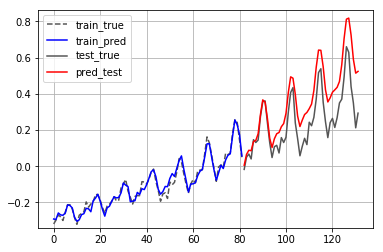

In [4]:
PRED_N = 300
model_ar = AR(train)
model_ar = model_ar.fit(disp=True)

pred_train = model_ar.predict(start=model_ar.k_ar, end=len(train)-1)
pred_test = model_ar.predict(start=len(train), end=len(train)+len(test)-1)
    
def show_result(train, test, train_pred, test_pred, lag):
    x_train = np.arange(len(train_pred))
    x_test = np.arange(len(train_pred), len(train_pred) + len(test_pred))
    
    ylim(np.min(train), np.max(test) + np.std(test)*1.3)
    plot(x_train, train[lag:], linestyle="--", label='train_true', color="#555555")
    plot(x_train, train_pred, label='train_pred', color='blue')
    plot(x_test, test, label='test_true',  color='#555555')
    plot(x_test, test_pred, label='pred_test', color='red')
    legend()
    grid()
        
    print('Lag:', lag)
    print('Train R^2:', r2_score(train_pred, train[lag:]))
    print('Train MSE:', mean_squared_error(train_pred, train[:-lag]))
    print('Test  R^2:', r2_score(test_pred, test))
    print('Test  MSE:', mean_squared_error(test_pred, test))

print('Params:', model_ar.params)
show_result(train, test, pred_train, pred_test, lag=model_ar.k_ar)

## Using Leastsquare


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     157.7
Date:                Tue, 08 Aug 2017   Prob (F-statistic):           1.13e-44
Time:                        18:07:31   Log-Likelihood:                 186.75
No. Observations:                  81   AIC:                            -347.5
Df Residuals:                      68   BIC:                            -316.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0654      0.007      8.853      0.000       0.051       0.080
x1            -0.2334      0.135     -1.723      0.089      -0.504       0.037
x2             1.1235      0.145      7.759      0.000       0.835       1.413
x3             0.0424      0.141      0.300      0.765      -0.240       0.325
x4             0.0441      0.136      0.324      0.747      -0.228       0.316
x5            -0.0295      0.135     -0.218      0.828      -0.299       0.240
x6            -0.0067      0.136     -0.049      0.961      -0.279       0.266
x7            -0.0773      0.136     -0.568      0.572      -0.349       0.194
x8             0.0986      0.134      0.736      0.464      -0.169       0.366
x9            -0.0521      0.132     -0.394      0.695      -0.316       0.212
x10            0.0649      0.133      0.488      0.627      -0.201       0.330
x11           -0.1361      0.132     -1.029      0.307      -0.400       0.128
x12            0.2821      0.120      2.357      0.021       0.043       0.521
==============================================================================
Omnibus:                        2.969   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                2.223
Skew:                          -0.339   Prob(JB):                        0.329
Kurtosis:                       3.445   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lag: 12
Train R^2: 0.853764985702
Train MSE: 0.00560402953505
Test  R^2: -0.18177910966
Test  MSE: 0.0561336321797


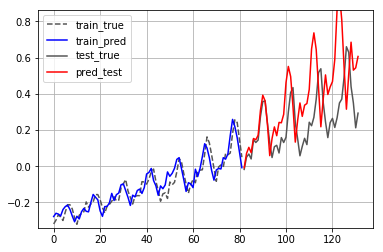

In [5]:
ols = sm.OLS(train[LAG+1:], sm.add_constant(ts_train)[:-1], )
ols = ols.fit()
display(ols.summary())

def predict_with_ols(ols, x, length):
    h = np.ones(x.shape[0] + 1)
    h[1:] = x
    
    response = list()
    for _ in range(length):
        p = ols.predict(h)
        h[1:-1] = h[2:]
        h[-1] = p
        response.append(p)
    response = np.array(response)
    return response

train_pred = ols.predict(sm.add_constant(ts_train))
test_pred = predict_with_ols(ols, ts_train[-1], length=len(test))

show_result(train, test, train_pred, test_pred, lag=LAG)

## Using Polynomial Curve Fitting

과거 12개 데이터를 통해서 그 다음을 예측합니다.

POLY: [ 1.14122357  0.07850594]
Lag: 12
Train R^2: 0.959204626599
Train MSE: 0.00333113179569
Test  R^2: 0.627872323225
Test  MSE: 0.0136219510639


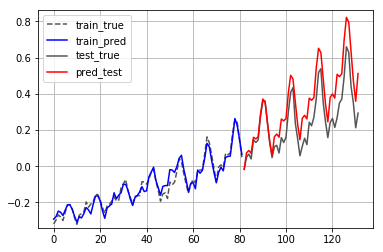

In [6]:
LAG = 12
DEGREE = 1

def poly_pred(poly, x, lag, length):
    h = x
    result = list()
    
    for _ in range(math.ceil(length/lag)):
        h = np.polyval(poly, h)
        result += h.reshape(-1).tolist()
        
    result = np.array(result[:length])
    return result

poly = np.polyfit(train[:-LAG].reshape(-1), train[LAG:].reshape(-1), DEGREE)
train_pred = np.polyval(poly, train[:-LAG])
test_pred = poly_pred(poly, train[-LAG:], lag=LAG, length=len(test)) # np.polyval(poly, train[-LAG:])

print('POLY:', poly)
show_result(train, test, train_pred, test_pred, lag=LAG)